<a href="https://colab.research.google.com/github/marcgym2/DE-101-Practices/blob/master/Avance_1_DatosMasivos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor
import time
import logging
import os

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') > 0.99:
                print("\nReached 99% accuracy so cancelling training!")

                # Stop training once the above condition is met
                self.model.stop_training = True

In [3]:
# directorios de las canciones
dir_banda = "/content/Songs"
dir_tumbados = "/content/Songs2"

# listas para almacenar los datos de entrenamiento y las etiquetas
X_train = []
y_train = []
spectrograms = []
num_segments = 20
duration = 5
df = pd.DataFrame(columns=['Archivo', 'Duración', 'Etiqueta'])

# verificar si los directorios existen
print(os.path.exists(dir_banda))
print(os.path.exists(dir_tumbados))

# enumerar los archivos en los directorios
print(os.listdir(dir_banda))
print(os.listdir(dir_tumbados))

True
True
['Todo tuyo CD 1 TRACK 7 (320).mp3', 'Pesado - Ojalá.mp3', 'Pesado - Aún Te Amo.mp3', 'Pesado - Pídeme.mp3', 'Pesado - Quiero Que Sepas (Live At Nuevo León México_2009).mp3', 'Pesado - Lágrimas amargas.mp3', 'Pesado - Ayúdame a olvidar.mp3', 'Pesado - Tú como si nada.mp3', 'Duelo De Estrellas Vol. 2 CD 1 TRACK 8 (320).mp3', 'Pesado_Chiquilla_Cariñosa_Live_At_Nuevo_León_México___2009.mp3', 'Pesado - Laurita Garza (En Vivo).mp3', 'Pesado - Loco.mp3', 'Pesado - Mi Primer Amor.mp3', 'Pesado - EL INFIERNO.mp3', 'Pesado - El Mil Amores.mp3', 'Pesado - Cielo Nublado Aka Cielo Nevado (En Vivo).mp3', 'Pesado - A chillar a otra parte.mp3', 'Pesado - Me Refiero A Ti (Live At Nuevo León México_2009).mp3', 'Pesado - Ojalá que te mueras.mp3', 'Pesado - Mientras Dormías.mp3', 'Pesado_Recuérdame_Y_Ven_Live_At_Nuevo_León_México_2009.mp3', 'Pesado - Que Aún Te Amo.mp3', 'Pesado - Día tras día.mp3', 'Pesado - Mi Cómplice (En Vivo).mp3', 'Pesado - Mi Promesa.mp3', 'Pesado -

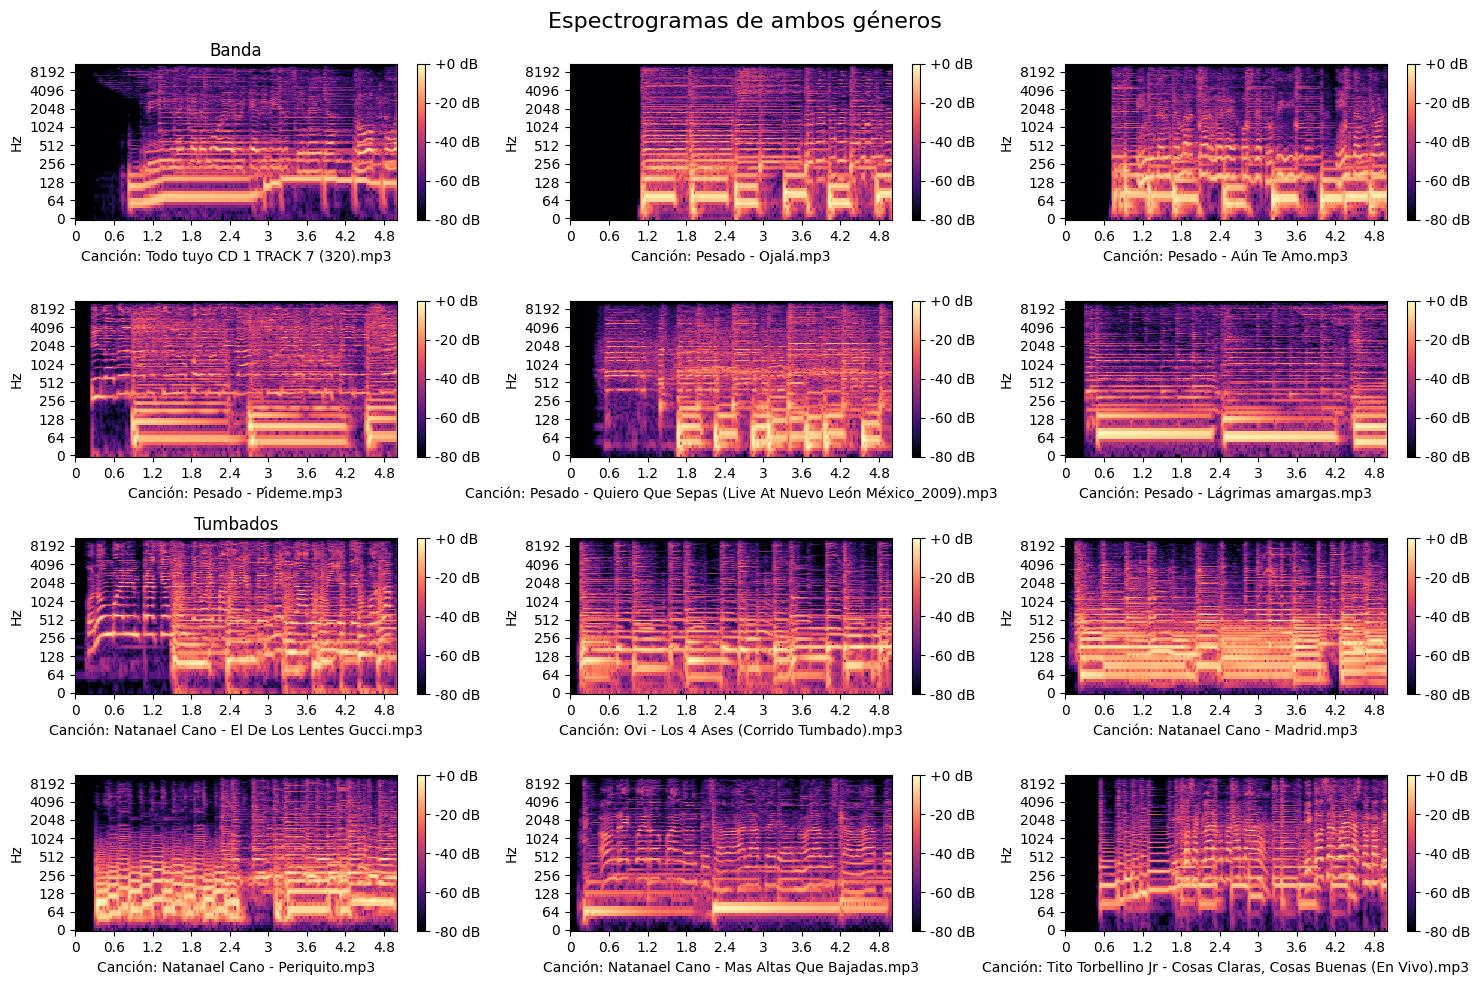

In [4]:
def process_files_and_update_df(dir_path, X_train, y_train, df, duration, label, num_segments):
    df_list = []
    spectrograms = []

    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith(".mp3"):
                file_path = os.path.join(root, file)

                for i in range(num_segments):
                    offset_time = i * duration
                    signal, sample_rate = librosa.load(file_path, sr=22050, offset=offset_time, duration=duration, res_type='soxr_lq')

                    if len(signal) < sample_rate * duration:
                        print(f"El segmento de la canción {file} es demasiado corto para {duration} segundos.")
                        continue

                    # Display an ordinary (linear) spectrogram, computing the short-time Fourier transform, and then mapping the magnitudes to a decibel scale.
                    D = librosa.stft(signal)  # STFT of signal
                    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

                    X_train.append(S_db)
                    y_train.append(label)

                    temp_df = pd.DataFrame({
                        'Archivo': [file],
                        'Duración': [duration],
                        'Etiqueta': [label]
                    })
                    df_list.append(temp_df)

                    spectrograms.append(S_db)

    df = pd.concat([df] + df_list, ignore_index=True)

    return X_train, y_train, df, spectrograms


def process_files(dir_path, duration, label):
    X_train = []
    y_train = []
    df = pd.DataFrame()
    spectrograms = []

    X_train, y_train, df, spectrograms = process_files_and_update_df(dir_path, X_train, y_train, df, duration, label, num_segments)
    return X_train, y_train, df, spectrograms

with ThreadPoolExecutor(max_workers=2) as executor:  # Incrementar el número de workers si es necesario
    future_banda = executor.submit(process_files, dir_banda, duration, 0)
    future_tumbados = executor.submit(process_files, dir_tumbados, duration, 1)

# Obtener resultados
X_train_banda, y_train_banda, df_banda, spectrograms_banda = future_banda.result()
X_train_tumbados, y_train_tumbados, df_tumbados, spectrograms_tumbados = future_tumbados.result()

# Combinar los resultados
X_train = X_train_banda + X_train_tumbados
y_train = y_train_banda + y_train_tumbados
df = pd.concat([df_banda, df_tumbados], ignore_index=True)
spectrograms = spectrograms_banda + spectrograms_tumbados

# Visualizar 12 espectrogramas, 6 de cada género
fig, ax = plt.subplots(4, 3, figsize=(15, 10))

fig.suptitle('Espectrogramas de ambos géneros', fontsize=16)

positions = [0, 20, 40, 60, 80, 100]  # Posiciones que quieres graficar

sample_rate = 22050
num_plots = 6
for i, pos in enumerate(positions):
    img = librosa.display.specshow(spectrograms_banda[pos], sr=sample_rate, x_axis='time', y_axis='log', ax=ax[i//3, i%3])
    if i == 0:
        ax[i//3, i%3].set_title("Banda")
    ax[i//3, i%3].set_xlabel(f"Canción: {df_banda['Archivo'][pos]}")
    fig.colorbar(img, ax=ax[i//3, i%3], format="%+2.f dB")

for i, pos in enumerate(positions):
    img = librosa.display.specshow(spectrograms_tumbados[pos], sr=sample_rate, x_axis='time', y_axis='log', ax=ax[(i + num_plots)//3, (i + num_plots)%3])
    if i == 0:
        ax[(i + num_plots)//3, (i + num_plots)%3].set_title("Tumbados")
    ax[(i + num_plots)//3, (i + num_plots)%3].set_xlabel(f"Canción: {df_tumbados['Archivo'][pos]}")
    fig.colorbar(img, ax=ax[(i + num_plots)//3, (i + num_plots)%3], format="%+2.f dB")

plt.tight_layout()
plt.show()


Ref https://codigofacilito.com/articulos/pool-threads-python

In [5]:
print(df)

                               Archivo  Duración  Etiqueta
0     Todo tuyo CD 1 TRACK 7 (320).mp3         5         0
1     Todo tuyo CD 1 TRACK 7 (320).mp3         5         0
2     Todo tuyo CD 1 TRACK 7 (320).mp3         5         0
3     Todo tuyo CD 1 TRACK 7 (320).mp3         5         0
4     Todo tuyo CD 1 TRACK 7 (320).mp3         5         0
...                                ...       ...       ...
1995          Dan Sanchez - Una 45.mp3         5         1
1996          Dan Sanchez - Una 45.mp3         5         1
1997          Dan Sanchez - Una 45.mp3         5         1
1998          Dan Sanchez - Una 45.mp3         5         1
1999          Dan Sanchez - Una 45.mp3         5         1

[2000 rows x 3 columns]


In [6]:
print("Espectograma 1, Sub-grupo 1")
print(spectrograms_banda[0])
print("-----------")
print("Espectograma 1,  Sub-grupo 2")
print(spectrograms_tumbados[0])


Espectograma 1, Sub-grupo 1
[[-80.       -80.       -80.       ... -73.72308  -48.244316 -46.680958]
 [-80.       -80.       -80.       ... -55.439888 -52.189957 -46.133713]
 [-80.       -80.       -80.       ... -59.902534 -54.13169  -44.977547]
 ...
 [-80.       -80.       -80.       ... -80.       -69.83484  -58.416626]
 [-80.       -80.       -80.       ... -80.       -69.83507  -58.416836]
 [-80.       -80.       -80.       ... -80.       -69.835205 -58.416916]]
-----------
Espectograma 1,  Sub-grupo 2
[[-76.00012  -80.       -79.112885 ... -24.95504  -26.214767 -27.832968]
 [-75.46799  -78.91592  -80.       ... -29.971514 -33.3085   -31.576168]
 [-74.29802  -80.       -80.       ... -50.49783  -43.734997 -36.671364]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -69.92691 ]
 [-80.       -80.       -80.       ... -80.       -80.       -69.92712 ]
 [-80.       -80.       -80.       ... -80.       -80.       -69.92715 ]]


In [7]:
# Convertir a numpy arrays

y_train = np.array(y_train)

X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
X_train = X_train/np.std(X_train)

# Añadir dimensión de canales si es necesario
if len(X_train.shape) == 3:
    X_train = np.expand_dims(X_train, axis=-1)

# Imprimir información detallada sobre los datos de entrenamiento
num_samples, num_frames, num_bins, num_channels = X_train.shape
input_shape = (num_frames, num_bins, num_channels)  # Define input_shape como una tupla de enteros
print(f"Total number of training samples: {num_samples}")
print(f"Each sample is a spectrogram of shape {input_shape[0]}x{input_shape[1]}x{input_shape[2]}")
print(f"Therefore, the input shape for the model should be {input_shape}")

# Imprimir información detallada sobre las etiquetas de entrenamiento
num_labels = y_train.shape[0]
unique_labels, counts_labels = np.unique(y_train, return_counts=True)
print(f"Total number of training labels: {num_labels}")
for label, count in zip(unique_labels, counts_labels):
    print(f"Label {label} appears {count} times")


Total number of training samples: 2000
Each sample is a spectrogram of shape 1025x216x1
Therefore, the input shape for the model should be (1025, 216, 1)
Total number of training labels: 2000
Label 0 appears 1000 times
Label 1 appears 1000 times


In [9]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# Inicializar un planificador de la tasa de aprendizaje que reduzca la tasa después de 10 épocas sin mejora
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

# Inicializar Early Stopping para detener el entrenamiento después de 12 épocas sin mejora
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)

# Compilar el modelo
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Entrenar el modelo
callbacks = myCallback()
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32,
                    callbacks=[lr_scheduler, early_stopping, callbacks])

Epoch 1/100
50/50 [==============================] - 125s 2s/step - loss: 2.0594 - accuracy: 0.6075 - val_loss: 0.7028 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 123s 2s/step - loss: 0.6873 - accuracy: 0.6250 - val_loss: 0.7412 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 123s 2s/step - loss: 0.6767 - accuracy: 0.6237 - val_loss: 0.7984 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 122s 2s/step - loss: 0.6531 - accuracy: 0.6250 - val_loss: 1.0061 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 123s 2s/step - loss: 0.6284 - accuracy: 0.6256 - val_loss: 0.7471 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 123s 2s/step - loss: 0.6326 - accuracy: 0.6463 - val_loss: 0.8932 - val_accuracy: 0.1925 - lr: 0.0010
Epoch 8/100
50/50 [==============================] - 1

In [10]:
# Imprimir un resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1023, 214, 64)     640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 511, 107, 64)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 511, 107, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 509, 105, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 254, 52, 64)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 254, 52, 64)      

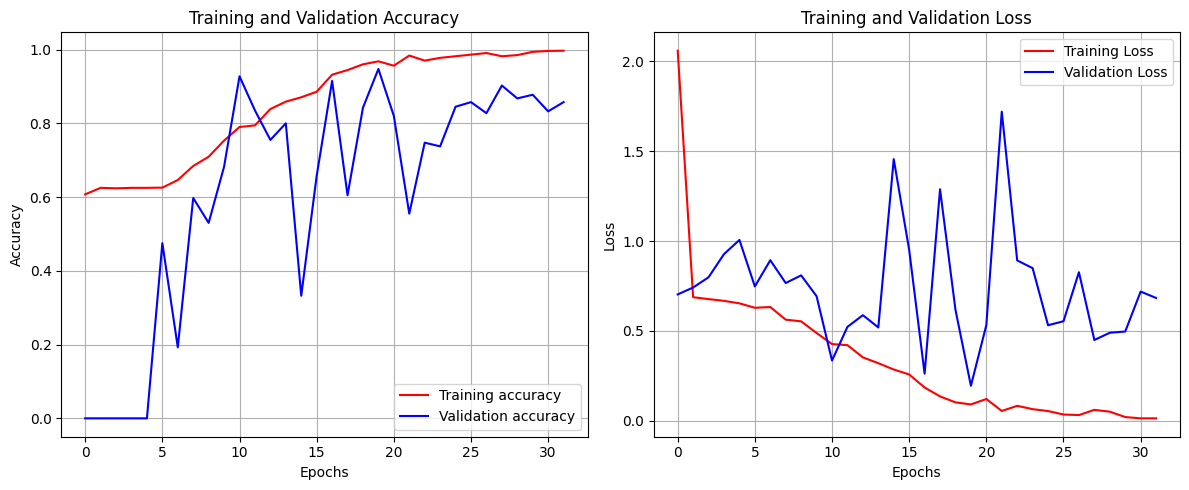

In [11]:
# Obtener los datos del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Crear una nueva figura
plt.figure(figsize=(12, 5))

# Subplot para la precisión
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Subplot para la pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Asegurarse de que los subplots no se superponen y mostrar el gráfico
plt.tight_layout()
plt.show()
